In [1]:
# Install PyTorch
!pip install -U torch==1.8.1+cu101 torchvision==0.9.1+cu101 -f https://download.pytorch.org/whl/torch_stable.html
# Install MMCV
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/index.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 763.7 MB 10 kB/s 
     |████████████████████████████████| 17.3 MB 33.8 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
torchaudio 0.10.0+cu111 requires torch==1.10.0, but you have torch 1.8.1+cu101 which is incompatible.
Looking in links: https://download.openmmlab.com/mmcv/dist/cu101/torch1.8.0/inde

In [2]:
!rm -rf tcc
!git clone https://github.com/matheussn/tcc.git
%cd tcc

Cloning into 'tcc'...
remote: Enumerating objects: 356, done.
remote: Counting objects: 100% (356/356), done.
remote: Compressing objects: 100% (244/244), done.
remote: Total 356 (delta 165), reused 279 (delta 91), pack-reused 0
Receiving objects: 100% (356/356), 38.13 MiB | 30.62 MiB/s, done.
Resolving deltas: 100% (165/165), done.
/content/tcc


In [3]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 6054, done.
remote: Counting objects: 100% (560/560), done.
remote: Compressing objects: 100% (383/383), done.
remote: Total 6054 (delta 295), reused 308 (delta 172), pack-reused 5494
Receiving objects: 100% (6054/6054), 12.60 MiB | 24.85 MiB/s, done.
Resolving deltas: 100% (4364/4364), done.
/content/tcc/mmsegmentation
Obtaining file:///content/tcc/mmsegmentation
  Running setup.py develop for mmsegmentation


In [4]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
from mmseg.datasets import build_dataset
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset
from mmseg.apis import set_random_seed, train_segmentor
from mmseg.models import build_segmentor
print(mmseg.__version__)

import mmcv
from mmcv import Config

import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt

1.8.1+cu101 True
0.21.1


In [5]:
!rm -rf segmentation/
!unzip ../../segmentation.zip

Archive:  ../../segmentation.zip
   creating: segmentation/
   creating: segmentation/annotations/
  inflating: segmentation/annotations/image020-roi1.tif  
  inflating: segmentation/annotations/image008-roi1.tif  
  inflating: segmentation/annotations/image032-roi1.tif  
  inflating: segmentation/annotations/image019-roi2.tif  
  inflating: segmentation/annotations/image019-roi5.tif  
  inflating: segmentation/annotations/image058-roi5.tif  
  inflating: segmentation/annotations/image038-roi4.tif  
  inflating: segmentation/annotations/image058-roi1.tif  
  inflating: segmentation/annotations/image021-roi3.tif  
  inflating: segmentation/annotations/image006-roi2.tif  
  inflating: segmentation/annotations/image021-roi6.tif  
  inflating: segmentation/annotations/image038-roi1.tif  
  inflating: segmentation/annotations/image003-2-roi3.tif  
  inflating: segmentation/annotations/image038-roi3.tif  
  inflating: segmentation/annotations/image039-roi3.tif  
  inflating: segmentation/ann

In [6]:
data_root = 'segmentation'
img_dir = 'images'
ann_dir = 'annotations'

In [7]:
classes = ('bg', 'cell')
palette = [[0, 0, 0], [255, 255, 255]]

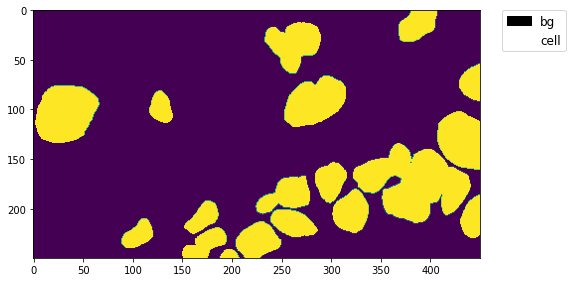

In [8]:
# Let's take a look at the segmentation map we got

img = Image.open('segmentation/annotations/image003-2-roi1.tif')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [9]:
# split train/val set randomly
split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(osp.join(data_root, ann_dir), suffix='.tif')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
    # select first 4/5 as train set
    train_length = int(len(filename_list)*4/5)
    f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
    # select last 1/5 as train set
    f.writelines(line + '\n' for line in filename_list[train_length:])

In [10]:
@DATASETS.register_module()
class DysplasiaDataSet(CustomDataset):
    CLASSES = classes
    PALETTE = palette
    def __init__(self, split, **kwargs):
        super().__init__(img_suffix='.jpg', seg_map_suffix='.tif', split=split, **kwargs)
        assert osp.exists(self.img_dir) and self.split is not None

In [11]:
cfg = Config.fromfile('../models/segformer.py')

In [12]:
cfg.runner.max_epochs = 50
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'DysplasiaDataSet'
data_root = 'segmentation'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (256, 256)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(320, 240), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=(256, 256), cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size=(256, 256), pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(256, 256),
        flip=False,
        transforms=[
            dict(type='R

In [13]:
datasets = [build_dataset(cfg.data.train)]

2022-02-16 23:53:53,035 - mmseg - INFO - Loaded 96 images


In [14]:
# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

In [15]:
# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, meta=dict())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
2022-02-16 23:53:57,121 - mmseg - INFO - Loaded 24 images
2022-02-16 23:53:57,130 - mmseg - INFO - Start running, host: root@11034dc8fb66, work_dir: /content/tcc/mmsegmentation/work_dirs/unet
2022-02-16 23:53:57,136 - mmseg - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) PolyLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 7.1 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:54:29,440 - mmseg - INFO - per class results:
2022-02-16 23:54:29,445 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 81.05 | 99.64 |
|  cell |  5.62 |  2.91 |
+-------+-------+-------+
2022-02-16 23:54:29,451 - mmseg - INFO - Summary:
2022-02-16 23:54:29,454 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 68.44 | 43.33 | 51.28 |
+-------+-------+-------+
2022-02-16 23:54:29,462 - mmseg - INFO - Epoch(val) [1][24]	aAcc: 0.6844, mDice: 0.4333, mAcc: 0.5128, Dice.bg: 0.8105, Dice.cell: 0.0562, Acc.bg: 0.9964, Acc.cell: 0.0291
2022-02-16 23:54:58,178 - mmseg - INFO - Epoch [2][12/12]	lr: 9.822e-03, eta: 0:21:55, time: 2.274, data_time: 0.231, memory: 5170, decode.loss_ce: 0.4561, decode.acc_seg: 72.2773, aux.loss_ce: 0.1814, aux.acc_seg: 71.2303, loss: 0.6375


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:55:00,748 - mmseg - INFO - per class results:
2022-02-16 23:55:00,751 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  84.0 | 98.11 |
|  cell | 39.37 | 25.48 |
+-------+-------+-------+
2022-02-16 23:55:00,752 - mmseg - INFO - Summary:
2022-02-16 23:55:00,755 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 74.68 | 61.68 | 61.79 |
+-------+-------+-------+
2022-02-16 23:55:00,763 - mmseg - INFO - Epoch(val) [2][24]	aAcc: 0.7468, mDice: 0.6168, mAcc: 0.6179, Dice.bg: 0.8400, Dice.cell: 0.3937, Acc.bg: 0.9811, Acc.cell: 0.2548
2022-02-16 23:55:28,920 - mmseg - INFO - Epoch [3][12/12]	lr: 9.643e-03, eta: 0:21:17, time: 2.228, data_time: 0.196, memory: 5170, decode.loss_ce: 0.4290, decode.acc_seg: 73.5081, aux.loss_ce: 0.1744, aux.acc_seg: 72.0875, loss: 0.6034


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:55:31,519 - mmseg - INFO - per class results:
2022-02-16 23:55:31,523 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.07 | 95.81 |
|  cell | 51.96 | 38.19 |
+-------+-------+-------+
2022-02-16 23:55:31,524 - mmseg - INFO - Summary:
2022-02-16 23:55:31,526 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 77.22 | 68.52 | 67.0 |
+-------+-------+------+
2022-02-16 23:55:31,528 - mmseg - INFO - Epoch(val) [3][24]	aAcc: 0.7722, mDice: 0.6852, mAcc: 0.6700, Dice.bg: 0.8507, Dice.cell: 0.5196, Acc.bg: 0.9581, Acc.cell: 0.3819
2022-02-16 23:55:59,598 - mmseg - INFO - Epoch [4][12/12]	lr: 9.464e-03, eta: 0:20:44, time: 2.221, data_time: 0.193, memory: 5170, decode.loss_ce: 0.3933, decode.acc_seg: 75.8183, aux.loss_ce: 0.1619, aux.acc_seg: 74.2176, loss: 0.5552


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.2 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:56:02,221 - mmseg - INFO - per class results:
2022-02-16 23:56:02,223 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.97 | 91.62 |
|  cell | 63.58 | 54.81 |
+-------+-------+-------+
2022-02-16 23:56:02,231 - mmseg - INFO - Summary:
2022-02-16 23:56:02,233 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 79.75 | 74.78 | 73.22 |
+-------+-------+-------+
2022-02-16 23:56:02,235 - mmseg - INFO - Epoch(val) [4][24]	aAcc: 0.7975, mDice: 0.7478, mAcc: 0.7322, Dice.bg: 0.8597, Dice.cell: 0.6358, Acc.bg: 0.9162, Acc.cell: 0.5481
2022-02-16 23:56:30,265 - mmseg - INFO - Epoch [5][12/12]	lr: 9.284e-03, eta: 0:20:13, time: 2.217, data_time: 0.191, memory: 5170, decode.loss_ce: 0.3912, decode.acc_seg: 76.8562, aux.loss_ce: 0.1593, aux.acc_seg: 76.2556, loss: 0.5504


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:56:32,848 - mmseg - INFO - per class results:
2022-02-16 23:56:32,850 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.41 | 91.67 |
|  cell | 65.29 | 56.95 |
+-------+-------+-------+
2022-02-16 23:56:32,852 - mmseg - INFO - Summary:
2022-02-16 23:56:32,854 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 80.47 | 75.85 | 74.31 |
+-------+-------+-------+
2022-02-16 23:56:32,865 - mmseg - INFO - Epoch(val) [5][24]	aAcc: 0.8047, mDice: 0.7585, mAcc: 0.7431, Dice.bg: 0.8641, Dice.cell: 0.6529, Acc.bg: 0.9167, Acc.cell: 0.5695
2022-02-16 23:57:00,935 - mmseg - INFO - Epoch [6][12/12]	lr: 9.104e-03, eta: 0:19:43, time: 2.221, data_time: 0.199, memory: 5170, decode.loss_ce: 0.3611, decode.acc_seg: 77.0040, aux.loss_ce: 0.1502, aux.acc_seg: 75.5466, loss: 0.5114


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:57:03,486 - mmseg - INFO - per class results:
2022-02-16 23:57:03,488 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.43 | 88.72 |
|  cell | 69.01 | 65.17 |
+-------+-------+-------+
2022-02-16 23:57:03,490 - mmseg - INFO - Summary:
2022-02-16 23:57:03,494 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.12 | 77.72 | 76.95 |
+-------+-------+-------+
2022-02-16 23:57:03,506 - mmseg - INFO - Epoch(val) [6][24]	aAcc: 0.8112, mDice: 0.7772, mAcc: 0.7695, Dice.bg: 0.8643, Dice.cell: 0.6901, Acc.bg: 0.8872, Acc.cell: 0.6517
2022-02-16 23:57:31,532 - mmseg - INFO - Epoch [7][12/12]	lr: 8.924e-03, eta: 0:19:15, time: 2.216, data_time: 0.192, memory: 5170, decode.loss_ce: 0.3624, decode.acc_seg: 79.5101, aux.loss_ce: 0.1480, aux.acc_seg: 78.3857, loss: 0.5104


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:57:34,109 - mmseg - INFO - per class results:
2022-02-16 23:57:34,111 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.07 | 87.62 |
|  cell | 72.31 | 71.35 |
+-------+-------+-------+
2022-02-16 23:57:34,114 - mmseg - INFO - Summary:
2022-02-16 23:57:34,123 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.37 | 79.69 | 79.48 |
+-------+-------+-------+
2022-02-16 23:57:34,124 - mmseg - INFO - Epoch(val) [7][24]	aAcc: 0.8237, mDice: 0.7969, mAcc: 0.7948, Dice.bg: 0.8707, Dice.cell: 0.7231, Acc.bg: 0.8762, Acc.cell: 0.7135
2022-02-16 23:58:02,157 - mmseg - INFO - Epoch [8][12/12]	lr: 8.743e-03, eta: 0:18:46, time: 2.218, data_time: 0.195, memory: 5170, decode.loss_ce: 0.3396, decode.acc_seg: 79.9862, aux.loss_ce: 0.1422, aux.acc_seg: 78.4376, loss: 0.4818


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:58:04,728 - mmseg - INFO - per class results:
2022-02-16 23:58:04,731 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.79 | 86.48 |
|  cell | 72.56 | 73.11 |
+-------+-------+-------+
2022-02-16 23:58:04,733 - mmseg - INFO - Summary:
2022-02-16 23:58:04,735 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.17 | 79.68 | 79.79 |
+-------+-------+-------+
2022-02-16 23:58:04,745 - mmseg - INFO - Epoch(val) [8][24]	aAcc: 0.8217, mDice: 0.7968, mAcc: 0.7979, Dice.bg: 0.8679, Dice.cell: 0.7256, Acc.bg: 0.8648, Acc.cell: 0.7311
2022-02-16 23:58:32,637 - mmseg - INFO - Epoch [9][12/12]	lr: 8.562e-03, eta: 0:18:18, time: 2.206, data_time: 0.185, memory: 5170, decode.loss_ce: 0.3461, decode.acc_seg: 80.1258, aux.loss_ce: 0.1431, aux.acc_seg: 78.9496, loss: 0.4892


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.2 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:58:35,250 - mmseg - INFO - per class results:
2022-02-16 23:58:35,252 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 85.96 | 84.64 |
|  cell | 71.86 | 74.17 |
+-------+-------+-------+
2022-02-16 23:58:35,254 - mmseg - INFO - Summary:
2022-02-16 23:58:35,258 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 81.26 | 78.91 | 79.41 |
+-------+-------+-------+
2022-02-16 23:58:35,262 - mmseg - INFO - Epoch(val) [9][24]	aAcc: 0.8126, mDice: 0.7891, mAcc: 0.7941, Dice.bg: 0.8596, Dice.cell: 0.7186, Acc.bg: 0.8464, Acc.cell: 0.7417
2022-02-16 23:59:03,397 - mmseg - INFO - Epoch [10][12/12]	lr: 8.381e-03, eta: 0:17:51, time: 2.226, data_time: 0.203, memory: 5170, decode.loss_ce: 0.3385, decode.acc_seg: 80.1082, aux.loss_ce: 0.1375, aux.acc_seg: 79.3879, loss: 0.4760
2022-02-16 23:59:03,400 - mmseg - INFO - Saving checkpoint at 10 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:59:07,257 - mmseg - INFO - per class results:
2022-02-16 23:59:07,260 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.38 | 88.17 |
|  cell | 72.74 | 71.35 |
+-------+-------+-------+
2022-02-16 23:59:07,262 - mmseg - INFO - Summary:
2022-02-16 23:59:07,264 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.75 | 80.06 | 79.76 |
+-------+-------+-------+
2022-02-16 23:59:07,271 - mmseg - INFO - Epoch(val) [10][24]	aAcc: 0.8275, mDice: 0.8006, mAcc: 0.7976, Dice.bg: 0.8738, Dice.cell: 0.7274, Acc.bg: 0.8817, Acc.cell: 0.7135
2022-02-16 23:59:35,204 - mmseg - INFO - Epoch [11][12/12]	lr: 8.199e-03, eta: 0:17:23, time: 2.209, data_time: 0.187, memory: 5170, decode.loss_ce: 0.3373, decode.acc_seg: 80.7328, aux.loss_ce: 0.1384, aux.acc_seg: 79.8692, loss: 0.4757


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-16 23:59:37,788 - mmseg - INFO - per class results:
2022-02-16 23:59:37,789 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.34 | 87.34 |
|  cell | 73.42 | 73.41 |
+-------+-------+-------+
2022-02-16 23:59:37,792 - mmseg - INFO - Summary:
2022-02-16 23:59:37,797 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.85 | 80.38 | 80.38 |
+-------+-------+-------+
2022-02-16 23:59:37,800 - mmseg - INFO - Epoch(val) [11][24]	aAcc: 0.8285, mDice: 0.8038, mAcc: 0.8038, Dice.bg: 0.8734, Dice.cell: 0.7342, Acc.bg: 0.8734, Acc.cell: 0.7341
2022-02-17 00:00:05,823 - mmseg - INFO - Epoch [12][12/12]	lr: 8.016e-03, eta: 0:16:56, time: 2.217, data_time: 0.196, memory: 5170, decode.loss_ce: 0.3415, decode.acc_seg: 80.9434, aux.loss_ce: 0.1419, aux.acc_seg: 79.9085, loss: 0.4834


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:00:08,380 - mmseg - INFO - per class results:
2022-02-17 00:00:08,383 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.61 | 88.21 |
|  cell | 73.41 | 72.34 |
+-------+-------+-------+
2022-02-17 00:00:08,386 - mmseg - INFO - Summary:
2022-02-17 00:00:08,388 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.09 | 80.51 | 80.28 |
+-------+-------+-------+
2022-02-17 00:00:08,400 - mmseg - INFO - Epoch(val) [12][24]	aAcc: 0.8309, mDice: 0.8051, mAcc: 0.8028, Dice.bg: 0.8761, Dice.cell: 0.7341, Acc.bg: 0.8821, Acc.cell: 0.7234
2022-02-17 00:00:36,399 - mmseg - INFO - Epoch [13][12/12]	lr: 7.833e-03, eta: 0:16:29, time: 2.215, data_time: 0.195, memory: 5170, decode.loss_ce: 0.3289, decode.acc_seg: 81.4194, aux.loss_ce: 0.1355, aux.acc_seg: 80.6270, loss: 0.4643


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:00:38,933 - mmseg - INFO - per class results:
2022-02-17 00:00:38,937 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.98 | 88.02 |
|  cell | 74.72 | 74.65 |
+-------+-------+-------+
2022-02-17 00:00:38,940 - mmseg - INFO - Summary:
2022-02-17 00:00:38,946 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.7 | 81.35 | 81.33 |
+------+-------+-------+
2022-02-17 00:00:38,949 - mmseg - INFO - Epoch(val) [13][24]	aAcc: 0.8370, mDice: 0.8135, mAcc: 0.8133, Dice.bg: 0.8798, Dice.cell: 0.7472, Acc.bg: 0.8802, Acc.cell: 0.7465
2022-02-17 00:01:06,972 - mmseg - INFO - Epoch [14][12/12]	lr: 7.650e-03, eta: 0:16:02, time: 2.218, data_time: 0.196, memory: 5170, decode.loss_ce: 0.3388, decode.acc_seg: 81.3217, aux.loss_ce: 0.1383, aux.acc_seg: 80.5969, loss: 0.4771


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.6 task/s, elapsed: 2s, ETA:     0s

2022-02-17 00:01:09,484 - mmseg - INFO - per class results:
2022-02-17 00:01:09,486 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.18 | 88.08 |
|  cell | 75.26 | 75.45 |
+-------+-------+-------+
2022-02-17 00:01:09,489 - mmseg - INFO - Summary:
2022-02-17 00:01:09,496 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 84.0 | 81.72 | 81.76 |
+------+-------+-------+
2022-02-17 00:01:09,497 - mmseg - INFO - Epoch(val) [14][24]	aAcc: 0.8400, mDice: 0.8172, mAcc: 0.8176, Dice.bg: 0.8818, Dice.cell: 0.7526, Acc.bg: 0.8808, Acc.cell: 0.7545
2022-02-17 00:01:37,508 - mmseg - INFO - Epoch [15][12/12]	lr: 7.466e-03, eta: 0:15:35, time: 2.216, data_time: 0.190, memory: 5170, decode.loss_ce: 0.3342, decode.acc_seg: 81.8231, aux.loss_ce: 0.1368, aux.acc_seg: 81.0446, loss: 0.4711


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:01:40,078 - mmseg - INFO - per class results:
2022-02-17 00:01:40,080 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.15 | 85.03 |
|  cell | 74.95 | 78.78 |
+-------+-------+-------+
2022-02-17 00:01:40,084 - mmseg - INFO - Summary:
2022-02-17 00:01:40,093 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.01 | 81.05 | 81.91 |
+-------+-------+-------+
2022-02-17 00:01:40,094 - mmseg - INFO - Epoch(val) [15][24]	aAcc: 0.8301, mDice: 0.8105, mAcc: 0.8191, Dice.bg: 0.8715, Dice.cell: 0.7495, Acc.bg: 0.8503, Acc.cell: 0.7878
2022-02-17 00:02:08,100 - mmseg - INFO - Epoch [16][12/12]	lr: 7.282e-03, eta: 0:15:08, time: 2.215, data_time: 0.194, memory: 5170, decode.loss_ce: 0.3353, decode.acc_seg: 81.0674, aux.loss_ce: 0.1381, aux.acc_seg: 80.1762, loss: 0.4734


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:02:10,641 - mmseg - INFO - per class results:
2022-02-17 00:02:10,645 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.69 |  86.4 |
|  cell |  75.3 | 77.62 |
+-------+-------+-------+
2022-02-17 00:02:10,647 - mmseg - INFO - Summary:
2022-02-17 00:02:10,650 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.57 | 81.49 | 82.01 |
+-------+-------+-------+
2022-02-17 00:02:10,660 - mmseg - INFO - Epoch(val) [16][24]	aAcc: 0.8357, mDice: 0.8149, mAcc: 0.8201, Dice.bg: 0.8769, Dice.cell: 0.7530, Acc.bg: 0.8640, Acc.cell: 0.7762
2022-02-17 00:02:38,628 - mmseg - INFO - Epoch [17][12/12]	lr: 7.097e-03, eta: 0:14:41, time: 2.212, data_time: 0.192, memory: 5170, decode.loss_ce: 0.3222, decode.acc_seg: 82.0091, aux.loss_ce: 0.1325, aux.acc_seg: 80.9256, loss: 0.4547


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.6 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:02:41,150 - mmseg - INFO - per class results:
2022-02-17 00:02:41,152 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.1 | 84.56 |
|  cell | 75.22 | 79.82 |
+-------+-------+-------+
2022-02-17 00:02:41,154 - mmseg - INFO - Summary:
2022-02-17 00:02:41,157 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.03 | 81.16 | 82.19 |
+-------+-------+-------+
2022-02-17 00:02:41,166 - mmseg - INFO - Epoch(val) [17][24]	aAcc: 0.8303, mDice: 0.8116, mAcc: 0.8219, Dice.bg: 0.8710, Dice.cell: 0.7522, Acc.bg: 0.8456, Acc.cell: 0.7982
2022-02-17 00:03:09,196 - mmseg - INFO - Epoch [18][12/12]	lr: 6.911e-03, eta: 0:14:14, time: 2.217, data_time: 0.194, memory: 5170, decode.loss_ce: 0.3102, decode.acc_seg: 82.2598, aux.loss_ce: 0.1284, aux.acc_seg: 81.3694, loss: 0.4386


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:03:11,748 - mmseg - INFO - per class results:
2022-02-17 00:03:11,751 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.76 | 87.19 |
|  cell | 74.81 | 75.83 |
+-------+-------+-------+
2022-02-17 00:03:11,754 - mmseg - INFO - Summary:
2022-02-17 00:03:11,758 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.52 | 81.28 | 81.51 |
+-------+-------+-------+
2022-02-17 00:03:11,761 - mmseg - INFO - Epoch(val) [18][24]	aAcc: 0.8352, mDice: 0.8128, mAcc: 0.8151, Dice.bg: 0.8776, Dice.cell: 0.7481, Acc.bg: 0.8719, Acc.cell: 0.7583
2022-02-17 00:03:39,750 - mmseg - INFO - Epoch [19][12/12]	lr: 6.725e-03, eta: 0:13:47, time: 2.214, data_time: 0.191, memory: 5170, decode.loss_ce: 0.3069, decode.acc_seg: 81.8775, aux.loss_ce: 0.1274, aux.acc_seg: 80.9517, loss: 0.4344


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:03:42,285 - mmseg - INFO - per class results:
2022-02-17 00:03:42,287 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.72 | 86.76 |
|  cell | 75.06 | 76.77 |
+-------+-------+-------+
2022-02-17 00:03:42,290 - mmseg - INFO - Summary:
2022-02-17 00:03:42,293 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.54 | 81.39 | 81.77 |
+-------+-------+-------+
2022-02-17 00:03:42,300 - mmseg - INFO - Epoch(val) [19][24]	aAcc: 0.8354, mDice: 0.8139, mAcc: 0.8177, Dice.bg: 0.8772, Dice.cell: 0.7506, Acc.bg: 0.8676, Acc.cell: 0.7677
2022-02-17 00:04:10,321 - mmseg - INFO - Epoch [20][12/12]	lr: 6.539e-03, eta: 0:13:20, time: 2.217, data_time: 0.197, memory: 5170, decode.loss_ce: 0.3080, decode.acc_seg: 82.4476, aux.loss_ce: 0.1269, aux.acc_seg: 81.7567, loss: 0.4349
2022-02-17 00:04:10,323 - mmseg - INFO - Saving checkpoint at 20 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:04:13,951 - mmseg - INFO - per class results:
2022-02-17 00:04:13,955 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.65 | 86.91 |
|  cell | 74.75 | 76.08 |
+-------+-------+-------+
2022-02-17 00:04:13,957 - mmseg - INFO - Summary:
2022-02-17 00:04:13,962 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 83.42 |  81.2 | 81.5 |
+-------+-------+------+
2022-02-17 00:04:13,965 - mmseg - INFO - Epoch(val) [20][24]	aAcc: 0.8342, mDice: 0.8120, mAcc: 0.8150, Dice.bg: 0.8765, Dice.cell: 0.7475, Acc.bg: 0.8691, Acc.cell: 0.7608
2022-02-17 00:04:41,968 - mmseg - INFO - Epoch [21][12/12]	lr: 6.351e-03, eta: 0:12:53, time: 2.214, data_time: 0.193, memory: 5170, decode.loss_ce: 0.3153, decode.acc_seg: 82.4459, aux.loss_ce: 0.1296, aux.acc_seg: 81.7613, loss: 0.4449


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:04:44,521 - mmseg - INFO - per class results:
2022-02-17 00:04:44,525 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.14 | 87.48 |
|  cell | 75.66 | 76.85 |
+-------+-------+-------+
2022-02-17 00:04:44,528 - mmseg - INFO - Summary:
2022-02-17 00:04:44,529 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.05 |  81.9 | 82.17 |
+-------+-------+-------+
2022-02-17 00:04:44,537 - mmseg - INFO - Epoch(val) [21][24]	aAcc: 0.8405, mDice: 0.8190, mAcc: 0.8217, Dice.bg: 0.8814, Dice.cell: 0.7566, Acc.bg: 0.8748, Acc.cell: 0.7685
2022-02-17 00:05:12,447 - mmseg - INFO - Epoch [22][12/12]	lr: 6.163e-03, eta: 0:12:26, time: 2.207, data_time: 0.186, memory: 5170, decode.loss_ce: 0.3089, decode.acc_seg: 82.1265, aux.loss_ce: 0.1255, aux.acc_seg: 81.7532, loss: 0.4345


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:05:14,994 - mmseg - INFO - per class results:
2022-02-17 00:05:14,998 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.27 |  84.0 |
|  cell | 76.15 | 82.14 |
+-------+-------+-------+
2022-02-17 00:05:15,000 - mmseg - INFO - Summary:
2022-02-17 00:05:15,008 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.4 | 81.71 | 83.07 |
+------+-------+-------+
2022-02-17 00:05:15,010 - mmseg - INFO - Epoch(val) [22][24]	aAcc: 0.8340, mDice: 0.8171, mAcc: 0.8307, Dice.bg: 0.8727, Dice.cell: 0.7615, Acc.bg: 0.8400, Acc.cell: 0.8214
2022-02-17 00:05:42,965 - mmseg - INFO - Epoch [23][12/12]	lr: 5.975e-03, eta: 0:11:59, time: 2.211, data_time: 0.190, memory: 5170, decode.loss_ce: 0.3155, decode.acc_seg: 82.1620, aux.loss_ce: 0.1293, aux.acc_seg: 81.4998, loss: 0.4448


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.6 task/s, elapsed: 2s, ETA:     0s

2022-02-17 00:05:45,476 - mmseg - INFO - per class results:
2022-02-17 00:05:45,479 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.84 | 83.02 |
|  cell |  75.8 | 82.79 |
+-------+-------+-------+
2022-02-17 00:05:45,481 - mmseg - INFO - Summary:
2022-02-17 00:05:45,485 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.95 | 81.32 | 82.91 |
+-------+-------+-------+
2022-02-17 00:05:45,495 - mmseg - INFO - Epoch(val) [23][24]	aAcc: 0.8295, mDice: 0.8132, mAcc: 0.8291, Dice.bg: 0.8684, Dice.cell: 0.7580, Acc.bg: 0.8302, Acc.cell: 0.8279
2022-02-17 00:06:13,407 - mmseg - INFO - Epoch [24][12/12]	lr: 5.786e-03, eta: 0:11:33, time: 2.208, data_time: 0.192, memory: 5170, decode.loss_ce: 0.2785, decode.acc_seg: 82.1401, aux.loss_ce: 0.1126, aux.acc_seg: 82.0241, loss: 0.3912


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:06:15,956 - mmseg - INFO - per class results:
2022-02-17 00:06:15,960 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.94 | 86.54 |
|  cell | 75.88 | 78.42 |
+-------+-------+-------+
2022-02-17 00:06:15,962 - mmseg - INFO - Summary:
2022-02-17 00:06:15,968 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.92 | 81.91 | 82.48 |
+-------+-------+-------+
2022-02-17 00:06:15,971 - mmseg - INFO - Epoch(val) [24][24]	aAcc: 0.8392, mDice: 0.8191, mAcc: 0.8248, Dice.bg: 0.8794, Dice.cell: 0.7588, Acc.bg: 0.8654, Acc.cell: 0.7842
2022-02-17 00:06:43,945 - mmseg - INFO - Epoch [25][12/12]	lr: 5.596e-03, eta: 0:11:06, time: 2.214, data_time: 0.189, memory: 5170, decode.loss_ce: 0.3009, decode.acc_seg: 82.6883, aux.loss_ce: 0.1232, aux.acc_seg: 82.1706, loss: 0.4241


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:06:46,487 - mmseg - INFO - per class results:
2022-02-17 00:06:46,491 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.06 | 84.42 |
|  cell | 75.22 |  80.0 |
+-------+-------+-------+
2022-02-17 00:06:46,494 - mmseg - INFO - Summary:
2022-02-17 00:06:46,500 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.0 | 81.14 | 82.21 |
+------+-------+-------+
2022-02-17 00:06:46,503 - mmseg - INFO - Epoch(val) [25][24]	aAcc: 0.8300, mDice: 0.8114, mAcc: 0.8221, Dice.bg: 0.8706, Dice.cell: 0.7522, Acc.bg: 0.8442, Acc.cell: 0.8000
2022-02-17 00:07:14,533 - mmseg - INFO - Epoch [26][12/12]	lr: 5.405e-03, eta: 0:10:39, time: 2.218, data_time: 0.194, memory: 5170, decode.loss_ce: 0.3203, decode.acc_seg: 82.1406, aux.loss_ce: 0.1295, aux.acc_seg: 81.8481, loss: 0.4498


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.6 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:07:17,043 - mmseg - INFO - per class results:
2022-02-17 00:07:17,047 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.8 | 86.26 |
|  cell | 75.71 | 78.48 |
+-------+-------+-------+
2022-02-17 00:07:17,049 - mmseg - INFO - Summary:
2022-02-17 00:07:17,058 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.75 | 81.75 | 82.37 |
+-------+-------+-------+
2022-02-17 00:07:17,060 - mmseg - INFO - Epoch(val) [26][24]	aAcc: 0.8375, mDice: 0.8175, mAcc: 0.8237, Dice.bg: 0.8780, Dice.cell: 0.7571, Acc.bg: 0.8626, Acc.cell: 0.7848
2022-02-17 00:07:45,076 - mmseg - INFO - Epoch [27][12/12]	lr: 5.214e-03, eta: 0:10:12, time: 2.216, data_time: 0.194, memory: 5170, decode.loss_ce: 0.3182, decode.acc_seg: 82.4738, aux.loss_ce: 0.1305, aux.acc_seg: 81.6619, loss: 0.4486


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:07:47,623 - mmseg - INFO - per class results:
2022-02-17 00:07:47,627 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.21 | 87.98 |
|  cell | 75.45 | 75.88 |
+-------+-------+-------+
2022-02-17 00:07:47,628 - mmseg - INFO - Summary:
2022-02-17 00:07:47,630 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.07 | 81.83 | 81.93 |
+-------+-------+-------+
2022-02-17 00:07:47,632 - mmseg - INFO - Epoch(val) [27][24]	aAcc: 0.8407, mDice: 0.8183, mAcc: 0.8193, Dice.bg: 0.8821, Dice.cell: 0.7545, Acc.bg: 0.8798, Acc.cell: 0.7588
2022-02-17 00:08:15,616 - mmseg - INFO - Epoch [28][12/12]	lr: 5.022e-03, eta: 0:09:46, time: 2.215, data_time: 0.195, memory: 5170, decode.loss_ce: 0.3049, decode.acc_seg: 83.0700, aux.loss_ce: 0.1230, aux.acc_seg: 82.7093, loss: 0.4279


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:08:18,158 - mmseg - INFO - per class results:
2022-02-17 00:08:18,163 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.32 | 84.72 |
|  cell | 75.68 | 80.41 |
+-------+-------+-------+
2022-02-17 00:08:18,165 - mmseg - INFO - Summary:
2022-02-17 00:08:18,167 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.33 |  81.5 | 82.56 |
+-------+-------+-------+
2022-02-17 00:08:18,170 - mmseg - INFO - Epoch(val) [28][24]	aAcc: 0.8333, mDice: 0.8150, mAcc: 0.8256, Dice.bg: 0.8732, Dice.cell: 0.7568, Acc.bg: 0.8472, Acc.cell: 0.8041
2022-02-17 00:08:46,142 - mmseg - INFO - Epoch [29][12/12]	lr: 4.829e-03, eta: 0:09:19, time: 2.213, data_time: 0.195, memory: 5170, decode.loss_ce: 0.2971, decode.acc_seg: 82.8289, aux.loss_ce: 0.1198, aux.acc_seg: 82.3375, loss: 0.4169


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:08:48,699 - mmseg - INFO - per class results:
2022-02-17 00:08:48,702 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 86.67 | 82.93 |
|  cell | 75.42 | 82.24 |
+-------+-------+-------+
2022-02-17 00:08:48,704 - mmseg - INFO - Summary:
2022-02-17 00:08:48,706 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 82.71 | 81.05 | 82.59 |
+-------+-------+-------+
2022-02-17 00:08:48,718 - mmseg - INFO - Epoch(val) [29][24]	aAcc: 0.8271, mDice: 0.8105, mAcc: 0.8259, Dice.bg: 0.8667, Dice.cell: 0.7542, Acc.bg: 0.8293, Acc.cell: 0.8224
2022-02-17 00:09:16,716 - mmseg - INFO - Epoch [30][12/12]	lr: 4.635e-03, eta: 0:08:52, time: 2.215, data_time: 0.190, memory: 5170, decode.loss_ce: 0.3085, decode.acc_seg: 82.9614, aux.loss_ce: 0.1246, aux.acc_seg: 82.5896, loss: 0.4331
2022-02-17 00:09:16,718 - mmseg - INFO - Saving checkpoint at 30 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.6 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:09:20,234 - mmseg - INFO - per class results:
2022-02-17 00:09:20,236 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.23 | 87.28 |
|  cell | 76.09 | 77.82 |
+-------+-------+-------+
2022-02-17 00:09:20,239 - mmseg - INFO - Summary:
2022-02-17 00:09:20,244 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.23 | 82.16 | 82.55 |
+-------+-------+-------+
2022-02-17 00:09:20,246 - mmseg - INFO - Epoch(val) [30][24]	aAcc: 0.8423, mDice: 0.8216, mAcc: 0.8255, Dice.bg: 0.8823, Dice.cell: 0.7609, Acc.bg: 0.8728, Acc.cell: 0.7782
2022-02-17 00:09:48,134 - mmseg - INFO - Epoch [31][12/12]	lr: 4.440e-03, eta: 0:08:26, time: 2.205, data_time: 0.182, memory: 5170, decode.loss_ce: 0.3085, decode.acc_seg: 82.9959, aux.loss_ce: 0.1250, aux.acc_seg: 82.7430, loss: 0.4335


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:09:50,725 - mmseg - INFO - per class results:
2022-02-17 00:09:50,728 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.02 | 87.04 |
|  cell | 75.67 | 77.43 |
+-------+-------+-------+
2022-02-17 00:09:50,731 - mmseg - INFO - Summary:
2022-02-17 00:09:50,732 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.94 | 81.84 | 82.24 |
+-------+-------+-------+
2022-02-17 00:09:50,741 - mmseg - INFO - Epoch(val) [31][24]	aAcc: 0.8394, mDice: 0.8184, mAcc: 0.8224, Dice.bg: 0.8802, Dice.cell: 0.7567, Acc.bg: 0.8704, Acc.cell: 0.7743
2022-02-17 00:10:18,585 - mmseg - INFO - Epoch [32][12/12]	lr: 4.244e-03, eta: 0:07:59, time: 2.202, data_time: 0.180, memory: 5170, decode.loss_ce: 0.2940, decode.acc_seg: 83.2640, aux.loss_ce: 0.1195, aux.acc_seg: 82.8944, loss: 0.4134


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:10:21,154 - mmseg - INFO - per class results:
2022-02-17 00:10:21,157 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  87.5 | 84.62 |
|  cell | 76.26 | 81.54 |
+-------+-------+-------+
2022-02-17 00:10:21,160 - mmseg - INFO - Summary:
2022-02-17 00:10:21,163 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.62 | 81.88 | 83.08 |
+-------+-------+-------+
2022-02-17 00:10:21,167 - mmseg - INFO - Epoch(val) [32][24]	aAcc: 0.8362, mDice: 0.8188, mAcc: 0.8308, Dice.bg: 0.8750, Dice.cell: 0.7626, Acc.bg: 0.8462, Acc.cell: 0.8154
2022-02-17 00:10:49,096 - mmseg - INFO - Epoch [33][12/12]	lr: 4.047e-03, eta: 0:07:32, time: 2.209, data_time: 0.188, memory: 5170, decode.loss_ce: 0.2855, decode.acc_seg: 83.3833, aux.loss_ce: 0.1155, aux.acc_seg: 83.0132, loss: 0.4011


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:10:51,660 - mmseg - INFO - per class results:
2022-02-17 00:10:51,662 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.03 | 85.82 |
|  cell | 76.72 | 80.77 |
+-------+-------+-------+
2022-02-17 00:10:51,666 - mmseg - INFO - Summary:
2022-02-17 00:10:51,670 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.19 | 82.38 | 83.29 |
+-------+-------+-------+
2022-02-17 00:10:51,675 - mmseg - INFO - Epoch(val) [33][24]	aAcc: 0.8419, mDice: 0.8238, mAcc: 0.8329, Dice.bg: 0.8803, Dice.cell: 0.7672, Acc.bg: 0.8582, Acc.cell: 0.8077
2022-02-17 00:11:19,525 - mmseg - INFO - Epoch [34][12/12]	lr: 3.849e-03, eta: 0:07:05, time: 2.203, data_time: 0.181, memory: 5170, decode.loss_ce: 0.2985, decode.acc_seg: 82.9402, aux.loss_ce: 0.1199, aux.acc_seg: 82.6656, loss: 0.4184


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:11:22,107 - mmseg - INFO - per class results:
2022-02-17 00:11:22,111 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.21 | 86.85 |
|  cell | 76.39 | 78.87 |
+-------+-------+-------+
2022-02-17 00:11:22,112 - mmseg - INFO - Summary:
2022-02-17 00:11:22,115 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.27 |  82.3 | 82.86 |
+-------+-------+-------+
2022-02-17 00:11:22,124 - mmseg - INFO - Epoch(val) [34][24]	aAcc: 0.8427, mDice: 0.8230, mAcc: 0.8286, Dice.bg: 0.8821, Dice.cell: 0.7639, Acc.bg: 0.8685, Acc.cell: 0.7887
2022-02-17 00:11:50,174 - mmseg - INFO - Epoch [35][12/12]	lr: 3.650e-03, eta: 0:06:39, time: 2.218, data_time: 0.196, memory: 5170, decode.loss_ce: 0.3204, decode.acc_seg: 82.7303, aux.loss_ce: 0.1317, aux.acc_seg: 82.1233, loss: 0.4521


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:11:52,753 - mmseg - INFO - per class results:
2022-02-17 00:11:52,756 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.74 |  86.1 |
|  cell | 75.69 | 78.66 |
+-------+-------+-------+
2022-02-17 00:11:52,760 - mmseg - INFO - Summary:
2022-02-17 00:11:52,764 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 83.7 | 81.72 | 82.38 |
+------+-------+-------+
2022-02-17 00:11:52,766 - mmseg - INFO - Epoch(val) [35][24]	aAcc: 0.8370, mDice: 0.8172, mAcc: 0.8238, Dice.bg: 0.8774, Dice.cell: 0.7569, Acc.bg: 0.8610, Acc.cell: 0.7866
2022-02-17 00:12:20,709 - mmseg - INFO - Epoch [36][12/12]	lr: 3.450e-03, eta: 0:06:12, time: 2.210, data_time: 0.190, memory: 5170, decode.loss_ce: 0.2943, decode.acc_seg: 82.9479, aux.loss_ce: 0.1179, aux.acc_seg: 82.7534, loss: 0.4122


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:12:23,262 - mmseg - INFO - per class results:
2022-02-17 00:12:23,266 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.44 | 84.67 |
|  cell | 76.05 | 81.12 |
+-------+-------+-------+
2022-02-17 00:12:23,269 - mmseg - INFO - Summary:
2022-02-17 00:12:23,276 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.52 | 81.75 | 82.89 |
+-------+-------+-------+
2022-02-17 00:12:23,279 - mmseg - INFO - Epoch(val) [36][24]	aAcc: 0.8352, mDice: 0.8175, mAcc: 0.8289, Dice.bg: 0.8744, Dice.cell: 0.7605, Acc.bg: 0.8467, Acc.cell: 0.8112
2022-02-17 00:12:51,222 - mmseg - INFO - Epoch [37][12/12]	lr: 3.248e-03, eta: 0:05:45, time: 2.210, data_time: 0.190, memory: 5170, decode.loss_ce: 0.3066, decode.acc_seg: 82.7341, aux.loss_ce: 0.1235, aux.acc_seg: 82.5296, loss: 0.4301


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:12:53,774 - mmseg - INFO - per class results:
2022-02-17 00:12:53,776 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  88.5 | 88.01 |
|  cell | 76.27 | 77.16 |
+-------+-------+-------+
2022-02-17 00:12:53,778 - mmseg - INFO - Summary:
2022-02-17 00:12:53,784 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.51 | 82.39 | 82.59 |
+-------+-------+-------+
2022-02-17 00:12:53,787 - mmseg - INFO - Epoch(val) [37][24]	aAcc: 0.8451, mDice: 0.8239, mAcc: 0.8259, Dice.bg: 0.8850, Dice.cell: 0.7627, Acc.bg: 0.8801, Acc.cell: 0.7716
2022-02-17 00:13:21,809 - mmseg - INFO - Epoch [38][12/12]	lr: 3.045e-03, eta: 0:05:19, time: 2.217, data_time: 0.195, memory: 5170, decode.loss_ce: 0.2978, decode.acc_seg: 83.4521, aux.loss_ce: 0.1205, aux.acc_seg: 83.0772, loss: 0.4183


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:13:24,390 - mmseg - INFO - per class results:
2022-02-17 00:13:24,395 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.19 |  86.5 |
|  cell | 76.62 | 79.71 |
+-------+-------+-------+
2022-02-17 00:13:24,398 - mmseg - INFO - Summary:
2022-02-17 00:13:24,403 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 84.31 |  82.4 | 83.1 |
+-------+-------+------+
2022-02-17 00:13:24,406 - mmseg - INFO - Epoch(val) [38][24]	aAcc: 0.8431, mDice: 0.8240, mAcc: 0.8310, Dice.bg: 0.8819, Dice.cell: 0.7662, Acc.bg: 0.8650, Acc.cell: 0.7971
2022-02-17 00:13:52,434 - mmseg - INFO - Epoch [39][12/12]	lr: 2.840e-03, eta: 0:04:52, time: 2.217, data_time: 0.195, memory: 5170, decode.loss_ce: 0.3017, decode.acc_seg: 83.5849, aux.loss_ce: 0.1232, aux.acc_seg: 83.1005, loss: 0.4249


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:13:55,012 - mmseg - INFO - per class results:
2022-02-17 00:13:55,014 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.39 | 87.16 |
|  cell | 76.64 | 78.88 |
+-------+-------+-------+
2022-02-17 00:13:55,018 - mmseg - INFO - Summary:
2022-02-17 00:13:55,020 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.49 | 82.51 | 83.02 |
+-------+-------+-------+
2022-02-17 00:13:55,031 - mmseg - INFO - Epoch(val) [39][24]	aAcc: 0.8449, mDice: 0.8251, mAcc: 0.8302, Dice.bg: 0.8839, Dice.cell: 0.7664, Acc.bg: 0.8716, Acc.cell: 0.7888
2022-02-17 00:14:23,000 - mmseg - INFO - Epoch [40][12/12]	lr: 2.634e-03, eta: 0:04:26, time: 2.212, data_time: 0.192, memory: 5170, decode.loss_ce: 0.2724, decode.acc_seg: 83.5583, aux.loss_ce: 0.1104, aux.acc_seg: 83.0807, loss: 0.3828
2022-02-17 00:14:23,002 - mmseg - INFO - Saving checkpoint at 40 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:14:26,617 - mmseg - INFO - per class results:
2022-02-17 00:14:26,620 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.83 | 85.28 |
|  cell | 76.61 | 81.28 |
+-------+-------+-------+
2022-02-17 00:14:26,624 - mmseg - INFO - Summary:
2022-02-17 00:14:26,627 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.99 | 82.22 | 83.28 |
+-------+-------+-------+
2022-02-17 00:14:26,638 - mmseg - INFO - Epoch(val) [40][24]	aAcc: 0.8399, mDice: 0.8222, mAcc: 0.8328, Dice.bg: 0.8783, Dice.cell: 0.7661, Acc.bg: 0.8528, Acc.cell: 0.8128
2022-02-17 00:14:54,625 - mmseg - INFO - Epoch [41][12/12]	lr: 2.426e-03, eta: 0:03:59, time: 2.214, data_time: 0.194, memory: 5170, decode.loss_ce: 0.2880, decode.acc_seg: 83.7013, aux.loss_ce: 0.1177, aux.acc_seg: 83.0756, loss: 0.4057


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:14:57,204 - mmseg - INFO - per class results:
2022-02-17 00:14:57,206 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.74 | 85.19 |
|  cell | 76.45 | 81.13 |
+-------+-------+-------+
2022-02-17 00:14:57,211 - mmseg - INFO - Summary:
2022-02-17 00:14:57,216 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.88 |  82.1 | 83.16 |
+-------+-------+-------+
2022-02-17 00:14:57,219 - mmseg - INFO - Epoch(val) [41][24]	aAcc: 0.8388, mDice: 0.8210, mAcc: 0.8316, Dice.bg: 0.8774, Dice.cell: 0.7645, Acc.bg: 0.8519, Acc.cell: 0.8113
2022-02-17 00:15:25,211 - mmseg - INFO - Epoch [42][12/12]	lr: 2.215e-03, eta: 0:03:32, time: 2.214, data_time: 0.190, memory: 5170, decode.loss_ce: 0.2988, decode.acc_seg: 83.5002, aux.loss_ce: 0.1211, aux.acc_seg: 83.0920, loss: 0.4198


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:15:27,779 - mmseg - INFO - per class results:
2022-02-17 00:15:27,784 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.85 | 85.31 |
|  cell | 76.63 | 81.26 |
+-------+-------+-------+
2022-02-17 00:15:27,788 - mmseg - INFO - Summary:
2022-02-17 00:15:27,789 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.01 | 82.24 | 83.29 |
+-------+-------+-------+
2022-02-17 00:15:27,793 - mmseg - INFO - Epoch(val) [42][24]	aAcc: 0.8401, mDice: 0.8224, mAcc: 0.8329, Dice.bg: 0.8785, Dice.cell: 0.7663, Acc.bg: 0.8531, Acc.cell: 0.8126
2022-02-17 00:15:55,830 - mmseg - INFO - Epoch [43][12/12]	lr: 2.003e-03, eta: 0:03:06, time: 2.219, data_time: 0.195, memory: 5170, decode.loss_ce: 0.3057, decode.acc_seg: 83.5720, aux.loss_ce: 0.1233, aux.acc_seg: 83.2529, loss: 0.4290


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:15:58,395 - mmseg - INFO - per class results:
2022-02-17 00:15:58,399 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  88.0 | 85.97 |
|  cell | 76.52 | 80.23 |
+-------+-------+-------+
2022-02-17 00:15:58,401 - mmseg - INFO - Summary:
2022-02-17 00:15:58,402 - mmseg - INFO - 
+-------+-------+------+
|  aAcc | mDice | mAcc |
+-------+-------+------+
| 84.12 | 82.26 | 83.1 |
+-------+-------+------+
2022-02-17 00:15:58,411 - mmseg - INFO - Epoch(val) [43][24]	aAcc: 0.8412, mDice: 0.8226, mAcc: 0.8310, Dice.bg: 0.8800, Dice.cell: 0.7652, Acc.bg: 0.8597, Acc.cell: 0.8023
2022-02-17 00:16:26,394 - mmseg - INFO - Epoch [44][12/12]	lr: 1.787e-03, eta: 0:02:39, time: 2.214, data_time: 0.193, memory: 5170, decode.loss_ce: 0.2864, decode.acc_seg: 83.6617, aux.loss_ce: 0.1161, aux.acc_seg: 83.2323, loss: 0.4025


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:16:28,951 - mmseg - INFO - per class results:
2022-02-17 00:16:28,953 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.84 | 85.16 |
|  cell | 76.75 | 81.68 |
+-------+-------+-------+
2022-02-17 00:16:28,962 - mmseg - INFO - Summary:
2022-02-17 00:16:28,964 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.04 |  82.3 | 83.42 |
+-------+-------+-------+
2022-02-17 00:16:28,966 - mmseg - INFO - Epoch(val) [44][24]	aAcc: 0.8404, mDice: 0.8230, mAcc: 0.8342, Dice.bg: 0.8784, Dice.cell: 0.7675, Acc.bg: 0.8516, Acc.cell: 0.8168
2022-02-17 00:16:56,948 - mmseg - INFO - Epoch [45][12/12]	lr: 1.569e-03, eta: 0:02:13, time: 2.213, data_time: 0.191, memory: 5170, decode.loss_ce: 0.2881, decode.acc_seg: 84.3905, aux.loss_ce: 0.1180, aux.acc_seg: 83.8857, loss: 0.4061


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:16:59,517 - mmseg - INFO - per class results:
2022-02-17 00:16:59,522 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.67 | 84.67 |
|  cell | 76.66 | 82.17 |
+-------+-------+-------+
2022-02-17 00:16:59,524 - mmseg - INFO - Summary:
2022-02-17 00:16:59,529 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.86 | 82.16 | 83.42 |
+-------+-------+-------+
2022-02-17 00:16:59,531 - mmseg - INFO - Epoch(val) [45][24]	aAcc: 0.8386, mDice: 0.8216, mAcc: 0.8342, Dice.bg: 0.8767, Dice.cell: 0.7666, Acc.bg: 0.8467, Acc.cell: 0.8217
2022-02-17 00:17:27,463 - mmseg - INFO - Epoch [46][12/12]	lr: 1.346e-03, eta: 0:01:46, time: 2.209, data_time: 0.190, memory: 5170, decode.loss_ce: 0.2806, decode.acc_seg: 83.4216, aux.loss_ce: 0.1133, aux.acc_seg: 82.9800, loss: 0.3939


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:17:30,043 - mmseg - INFO - per class results:
2022-02-17 00:17:30,045 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 87.75 | 84.84 |
|  cell | 76.74 | 82.08 |
+-------+-------+-------+
2022-02-17 00:17:30,048 - mmseg - INFO - Summary:
2022-02-17 00:17:30,051 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 83.95 | 82.24 | 83.46 |
+-------+-------+-------+
2022-02-17 00:17:30,055 - mmseg - INFO - Epoch(val) [46][24]	aAcc: 0.8395, mDice: 0.8224, mAcc: 0.8346, Dice.bg: 0.8775, Dice.cell: 0.7674, Acc.bg: 0.8484, Acc.cell: 0.8208
2022-02-17 00:17:57,974 - mmseg - INFO - Epoch [47][12/12]	lr: 1.120e-03, eta: 0:01:19, time: 2.208, data_time: 0.188, memory: 5170, decode.loss_ce: 0.2950, decode.acc_seg: 83.0885, aux.loss_ce: 0.1186, aux.acc_seg: 82.8811, loss: 0.4136


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:18:00,506 - mmseg - INFO - per class results:
2022-02-17 00:18:00,510 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.19 | 86.13 |
|  cell | 76.92 | 80.69 |
+-------+-------+-------+
2022-02-17 00:18:00,513 - mmseg - INFO - Summary:
2022-02-17 00:18:00,515 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.38 | 82.55 | 83.41 |
+-------+-------+-------+
2022-02-17 00:18:00,517 - mmseg - INFO - Epoch(val) [47][24]	aAcc: 0.8438, mDice: 0.8255, mAcc: 0.8341, Dice.bg: 0.8819, Dice.cell: 0.7692, Acc.bg: 0.8613, Acc.cell: 0.8069
2022-02-17 00:18:28,474 - mmseg - INFO - Epoch [48][12/12]	lr: 8.870e-04, eta: 0:00:53, time: 2.211, data_time: 0.191, memory: 5170, decode.loss_ce: 0.2924, decode.acc_seg: 84.0193, aux.loss_ce: 0.1202, aux.acc_seg: 83.4882, loss: 0.4126


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.5 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:18:31,027 - mmseg - INFO - per class results:
2022-02-17 00:18:31,033 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  88.3 |  86.4 |
|  cell | 77.01 | 80.49 |
+-------+-------+-------+
2022-02-17 00:18:31,034 - mmseg - INFO - Summary:
2022-02-17 00:18:31,042 - mmseg - INFO - 
+------+-------+-------+
| aAcc | mDice |  mAcc |
+------+-------+-------+
| 84.5 | 82.66 | 83.45 |
+------+-------+-------+
2022-02-17 00:18:31,044 - mmseg - INFO - Epoch(val) [48][24]	aAcc: 0.8450, mDice: 0.8266, mAcc: 0.8345, Dice.bg: 0.8830, Dice.cell: 0.7701, Acc.bg: 0.8640, Acc.cell: 0.8049
2022-02-17 00:18:59,016 - mmseg - INFO - Epoch [49][12/12]	lr: 6.464e-04, eta: 0:00:26, time: 2.212, data_time: 0.192, memory: 5170, decode.loss_ce: 0.2759, decode.acc_seg: 83.0713, aux.loss_ce: 0.1110, aux.acc_seg: 82.9350, loss: 0.3868


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.4 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:19:01,568 - mmseg - INFO - per class results:
2022-02-17 00:19:01,572 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  | 88.21 | 86.04 |
|  cell | 77.04 | 81.03 |
+-------+-------+-------+
2022-02-17 00:19:01,573 - mmseg - INFO - Summary:
2022-02-17 00:19:01,579 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.42 | 82.63 | 83.53 |
+-------+-------+-------+
2022-02-17 00:19:01,582 - mmseg - INFO - Epoch(val) [49][24]	aAcc: 0.8442, mDice: 0.8263, mAcc: 0.8353, Dice.bg: 0.8821, Dice.cell: 0.7704, Acc.bg: 0.8604, Acc.cell: 0.8103
2022-02-17 00:19:29,604 - mmseg - INFO - Epoch [50][12/12]	lr: 3.928e-04, eta: 0:00:00, time: 2.217, data_time: 0.196, memory: 5170, decode.loss_ce: 0.3043, decode.acc_seg: 83.7920, aux.loss_ce: 0.1232, aux.acc_seg: 83.4643, loss: 0.4275
2022-02-17 00:19:29,606 - mmseg - INFO - Saving checkpoint at 50 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 24/24, 9.3 task/s, elapsed: 3s, ETA:     0s

2022-02-17 00:19:33,224 - mmseg - INFO - per class results:
2022-02-17 00:19:33,226 - mmseg - INFO - 
+-------+-------+-------+
| Class |  Dice |  Acc  |
+-------+-------+-------+
|   bg  |  88.1 | 85.63 |
|  cell | 77.07 | 81.61 |
+-------+-------+-------+
2022-02-17 00:19:33,228 - mmseg - INFO - Summary:
2022-02-17 00:19:33,233 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc | mDice |  mAcc |
+-------+-------+-------+
| 84.33 | 82.59 | 83.62 |
+-------+-------+-------+
2022-02-17 00:19:33,242 - mmseg - INFO - Epoch(val) [50][24]	aAcc: 0.8433, mDice: 0.8259, mAcc: 0.8362, Dice.bg: 0.8810, Dice.cell: 0.7707, Acc.bg: 0.8563, Acc.cell: 0.8161


/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

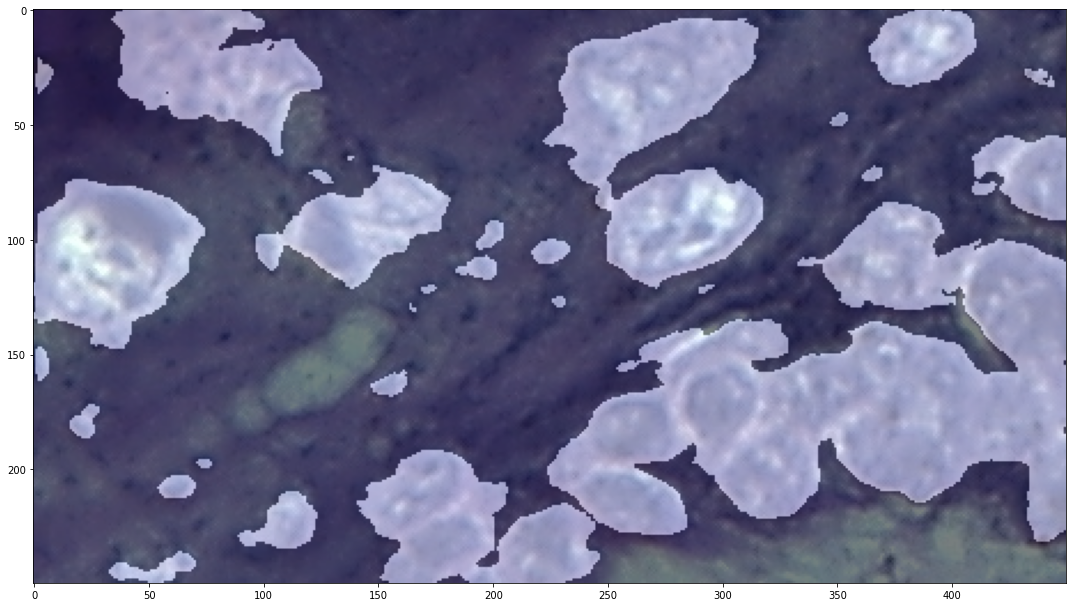

In [16]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

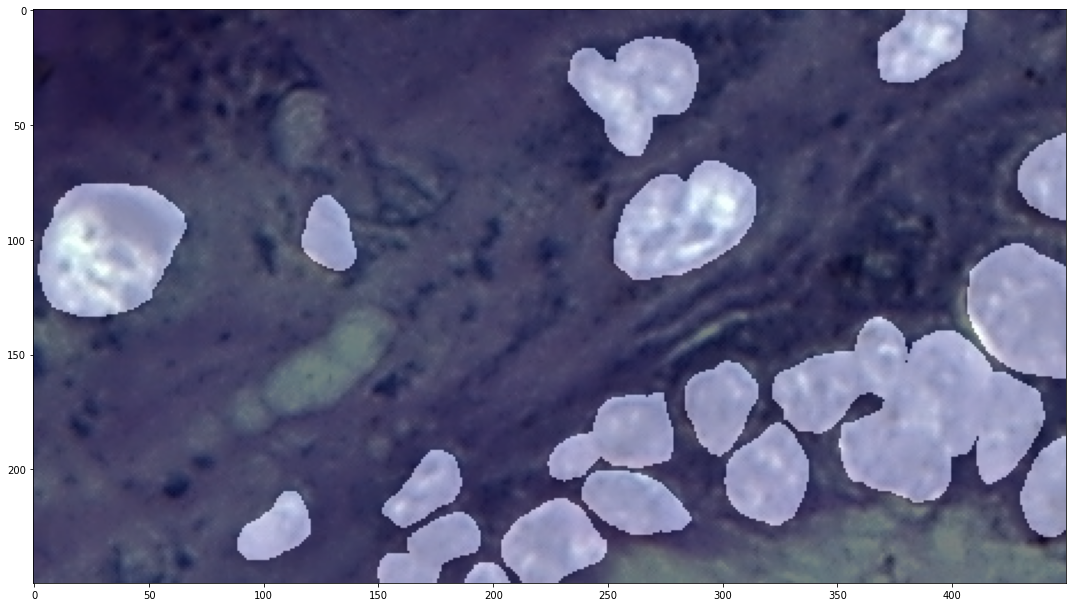

In [17]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image003-2-roi1.jpg')
result = mmcv.imread('segmentation/annotations/image003-2-roi1.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

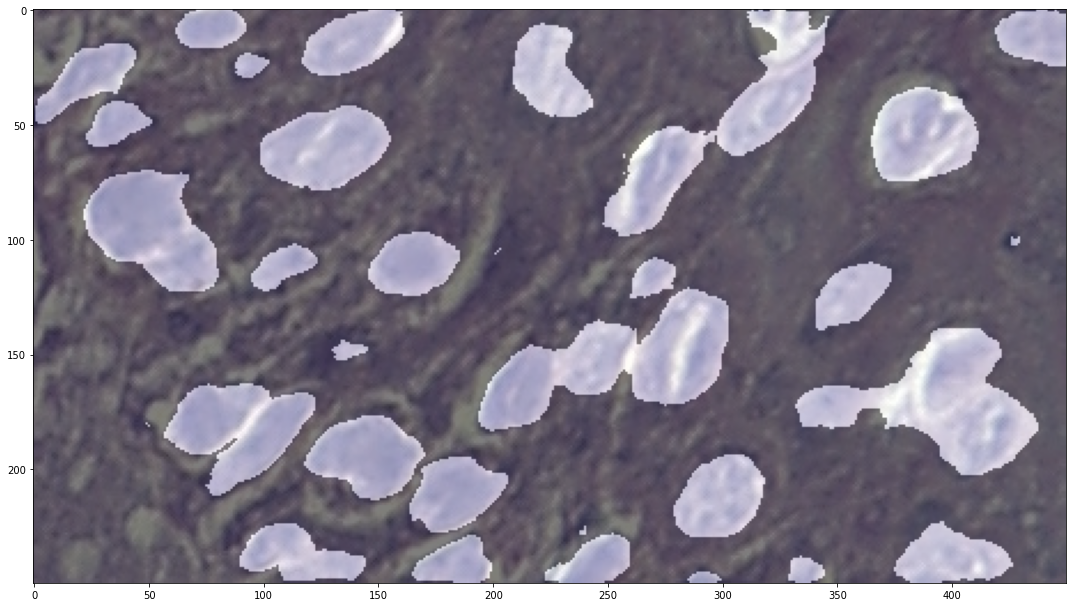

In [18]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image037-roi4.jpg')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

/content/tcc/mmsegmentation/mmseg/models/segmentors/base.py:284: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

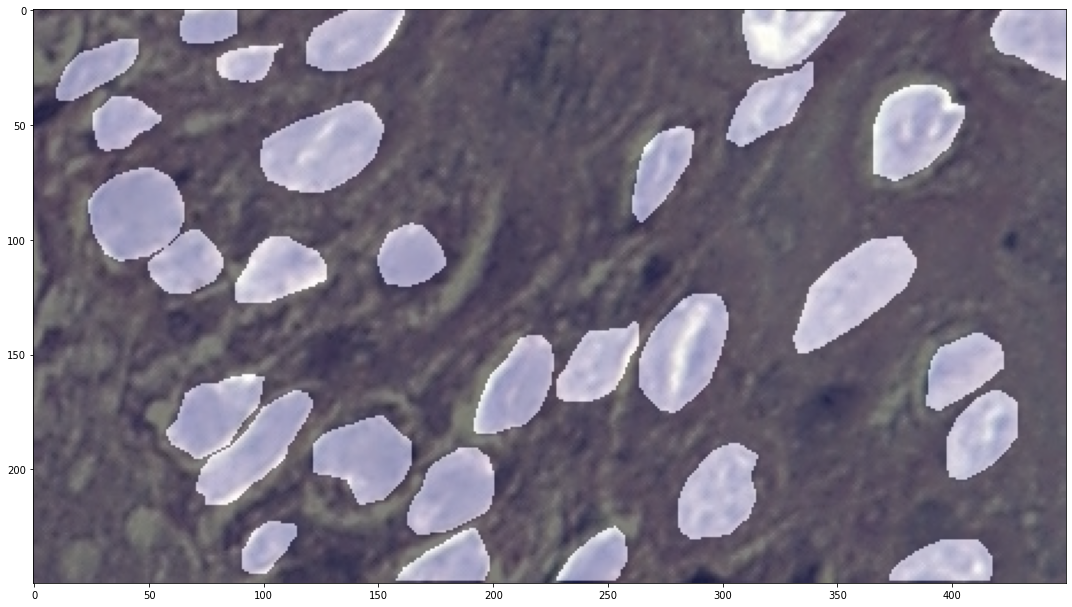

In [19]:
from mmseg.apis import inference_segmentor, show_result_pyplot
img = mmcv.imread('segmentation/images/image037-roi4.jpg')
result = mmcv.imread('segmentation/annotations/image037-roi4.tif',flag='grayscale')

model.cfg = cfg
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, [result], palette)

In [20]:
from glob import glob
images_glob = glob('segmentation/images/*')

train_images = []
for img_path in images_glob:
    img = mmcv.imread(img_path)
    train_images.append((img, 'result/'+img_path[20:]))

In [21]:
%rm -rf result

In [22]:
%mkdir result

In [23]:
import cv2 as cv
opacity = 0.5
fig_size=(15, 10)
for img, path in train_images:
  model.cfg = cfg
  result = inference_segmentor(model, img)
  predict_img = result[0]
  predict_img[predict_img == 1] = 255
  predict_img[predict_img == 0] = 0
  cv.imwrite(f'{path[:-4]}.png', predict_img)

In [24]:
%matplotlib inline
import json

file = open('./work_dirs/segformer/None.log.json')
lines = file.readlines()

m_dice = []
m_acc = []
loss = []

for line in lines:
    json_line = json.loads(line)
    if len(json_line):
        if json_line['mode'] == 'train':
            loss.append(json_line['loss'])
        else:
            m_acc.append(json_line['mAcc'])
            m_dice.append(json_line['mDice'])

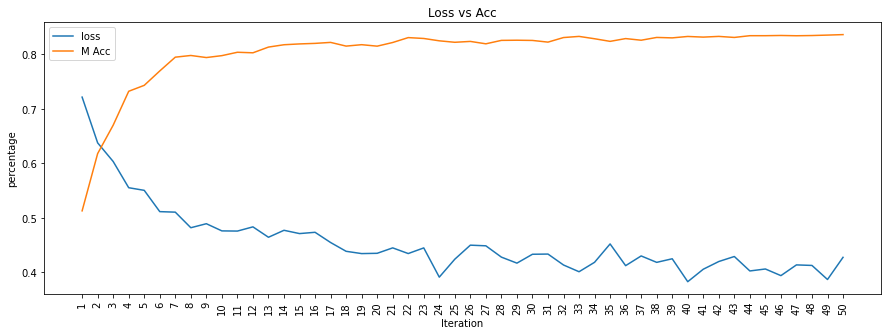

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), loss, label="loss")
plt.plot(range(1, len(m_acc) + 1), m_acc, label="M Acc")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("Loss vs Acc")
plt.xlabel("Iteration")
plt.ylabel("percentage")
plt.legend()
plt.savefig('Loss_vs_Acc_Graph.png')
plt.show()

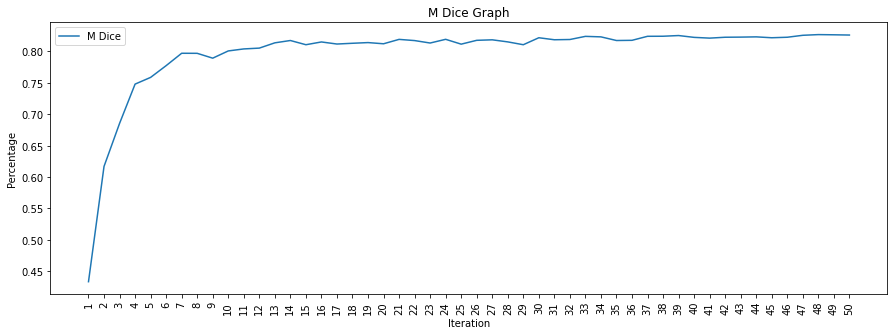

In [26]:
plt.figure(figsize=(15, 5))
plt.plot(range(1, len(m_acc) + 1), m_dice, label="M Dice")
plt.xticks(range(1, len(m_acc) + 1), rotation=90)
plt.title("M Dice Graph")
plt.xlabel("Iteration")
plt.ylabel("Percentage")
plt.legend()
plt.savefig('M_Dice_Graph.png')
plt.show()
plt.close()

In [27]:
from zipfile import ZipFile

with ZipFile('segformer_results.zip', 'w') as zipObj2:
  images_glob = glob('result/*')

  train_images = []
  for img_path in images_glob:
    zipObj2.write(img_path)